<a href="https://colab.research.google.com/github/yasinnerten/graduation-thesis/blob/main/Metro%20Istanbul%20Usage%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ortamın hazır hale getirilmesi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from PIL import Image

# For external libraries, use pip in your setup environment, not directly in the script
!apt install graphviz
!pip install sktime
!pip install pydot

# If you need to interact with tar files or make web requests, you might use:
import tarfile
import requests
from io import BytesIO

print('Ortam Hazır')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Ortam Hazır


In [ ]:
def load_data(url):
  url = url_august
  response = requests.get(url_august)

  with tarfile.open(fileobj=BytesIO(response.content), mode='r:xz') as tar:

      csv_file_name = tar.getnames()[0]
      data_august = tar.extractfile(csv_file_name)

      # Read the extracted file into a pandas DataFrame
      data = pd.read_csv(data_august)
  return data

### Verinin Yüklenmesi

In [ ]:
# Load the data
#url_github = 'https://raw.githubusercontent.com/yasinnerten/graduation-thesis/main/m2_tam_bilet_41k.csv'
#data_github = pd.read_csv(url_github)

#url_september = 'https://data.ibb.gov.tr/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/4546fb79-e598-4dc7-888b-626361110e37/download/hourly_transportation_202409.csv'

url_august = 'https://github.com/yasinnerten/graduation-thesis/raw/refs/heads/main/hourly_transportation_202408.tar.xz'
data = load_data(url_august)
data.head()

,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,product_kind,transaction_type_desc,town,line_name,station_poi_desc_cd
0,2024-08-01,0,1,OTOYOL,MESCIDI SELAM-ARNAVUTKOY-ISTANBUL HAVA LIMANI,Normal,1,1,TAM,Tam Kontur,ATASEHIR,H-6,NaN
1,2024-08-01,0,1,OTOYOL,MECIDIYEKOY-ISTANBUL HAVALIMANI,Normal,1,1,INDIRIMLI1,Indirimli Abonman,ATASEHIR,H-2,NaN
2,2024-08-01,0,1,OTOYOL,KOC UNV. RUMELIFENER KAMPUSU - TAKSIM,Normal,3,3,TAM,Tam Kontur,ATASEHIR,40,NaN
3,2024-08-01,0,1,OTOYOL,HACI OSMAN METRO - RUMELI FENERI,Aktarma,1,1,TAM,Tam Aktarma,ATASEHIR,150,NaN
4,2024-08-01,0,1,OTOYOL,USKUDAR-GUZELTEPE-UMRANIYE DEVLET HASTANESI,Normal,3,3,TAM,Tam Kontur,BAKIRKOY,15B,NaN


### Verinin Hazırlanması

In [ ]:
veri_filtreleme = data[
    (data['line_name'] == "M2") &
    (data['transport_type_id'] == 2)
]
veri_filtreleme
#&(data['station_poi_desc_cd'] == "YENIKAPI GUNEY")

,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,product_kind,transaction_type_desc,town,line_name,station_poi_desc_cd
28,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,1,1,UCRETSIZ,Ucretsiz,FATIH,M2,YENIKAPI GUNEY
29,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,1,1,TAM,Tam Kontur,FATIH,M2,YENIKAPI KUZEY
35,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,15,15,INDIRIMLI1,Indirimli Abonman,FATIH,M2,YENIKAPI GUNEY
70,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,5,4,TAM,TekliBilet Tarifeli,BEYOGLU,M2,TAKSIM GUNEY
119,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,10,10,INDIRIMLI1,Indirimli Kontur,BEYOGLU,M2,SISHANE KUZEY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953988,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,5,3,UCRETSIZ,Ucretsiz,BEYOGLU,M2,SISHANE KUZEY
2953999,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,6,6,UCRETSIZ,Ucretsiz,SISLI,M2,LEVENT 2 KUZEY
2954012,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Aktarma,1,1,UCRETSIZ,Tam Aktarma,BEYOGLU,M2,SISHANE KUZEY
2954034,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Aktarma,53,53,INDIRIMLI1,Indirimli Aktarma,SISLI,M2,SISLI 2 KUZEY


In [ ]:
veri_temizleme = veri_filtreleme.drop(columns=[
    'line_name', 'transport_type_id', 'product_kind',
    'transaction_type_desc', 'number_of_passage', 'town',
    'line', 'transfer_type', 'road_type'
], errors='ignore')
veri_temizleme

,transition_date,transition_hour,number_of_passenger,station_poi_desc_cd
28,2024-08-01,0,1,YENIKAPI GUNEY
29,2024-08-01,0,1,YENIKAPI KUZEY
35,2024-08-01,0,15,YENIKAPI GUNEY
70,2024-08-01,0,4,TAKSIM GUNEY
119,2024-08-01,0,10,SISHANE KUZEY
...,...,...,...,...
2953988,2024-08-31,23,3,SISHANE KUZEY
2953999,2024-08-31,23,6,LEVENT 2 KUZEY
2954012,2024-08-31,23,1,SISHANE KUZEY
2954034,2024-08-31,23,53,SISLI 2 KUZEY


In [ ]:
grouped_data = veri_temizleme.groupby(['transition_date', 'transition_hour','station_poi_desc_cd'], as_index=False)['number_of_passenger'].sum()
grouped_data

,transition_date,transition_hour,station_poi_desc_cd,number_of_passenger
0,2024-08-01,0,4 LEVENT 2 GUNEY,12
1,2024-08-01,0,4 LEVENT KUZEY,25
2,2024-08-01,0,ATATURK OTO SANAYI GUNEY,3
3,2024-08-01,0,ATATURK OTO SANAYI KUZEY,2
4,2024-08-01,0,DARUSSAFAKA,2
...,...,...,...,...
3977,2024-08-31,23,TAKSIM GUNEY,1474
3978,2024-08-31,23,VEZNECILER GUNEY,136
3979,2024-08-31,23,VEZNECILER KUZEY,81
3980,2024-08-31,23,YENIKAPI GUNEY,348


In [ ]:
# Haftanın gününü ekleme
grouped_data['transition_date'] = pd.to_datetime(grouped_data['transition_date'])
grouped_data['day_of_week'] = pd.to_datetime(grouped_data['transition_date']).dt.dayofweek

# Zaman serisi verisi: transition_date ve transition_hour'a göre sıralama
grouped_data = grouped_data.sort_values(by=['transition_date', 'transition_hour']).reset_index(drop=True)
grouped_data

,transition_date,transition_hour,station_poi_desc_cd,number_of_passenger,day_of_week
0,2024-08-01,0,4 LEVENT 2 GUNEY,12,3
1,2024-08-01,0,4 LEVENT KUZEY,25,3
2,2024-08-01,0,ATATURK OTO SANAYI GUNEY,3,3
3,2024-08-01,0,ATATURK OTO SANAYI KUZEY,2,3
4,2024-08-01,0,DARUSSAFAKA,2,3
...,...,...,...,...,...
3977,2024-08-31,23,TAKSIM GUNEY,1474,5
3978,2024-08-31,23,VEZNECILER GUNEY,136,5
3979,2024-08-31,23,VEZNECILER KUZEY,81,5
3980,2024-08-31,23,YENIKAPI GUNEY,348,5


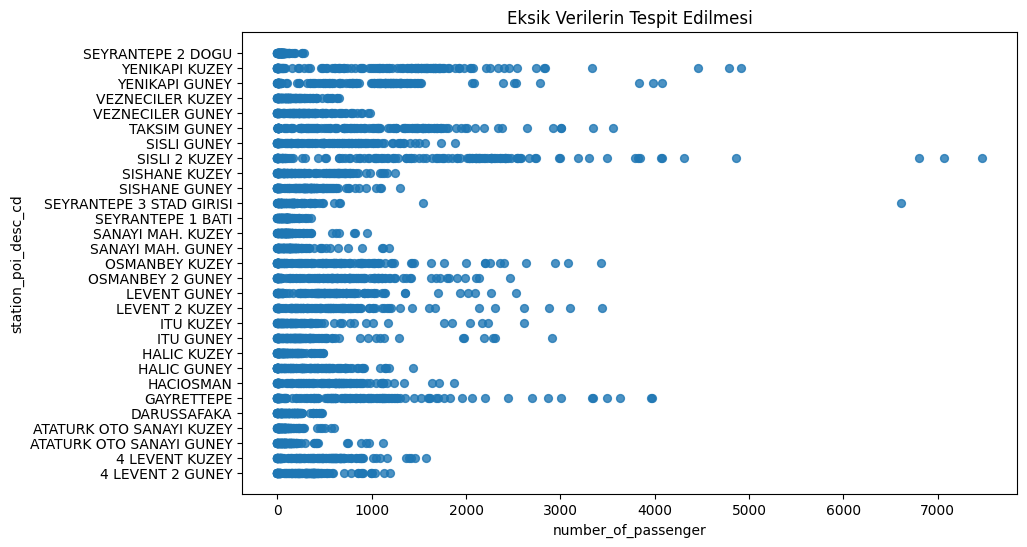

In [ ]:
from matplotlib import pyplot as plt
grouped_data.plot(kind='scatter', x='number_of_passenger', title="Eksik Verilerin Tespit Edilmesi", y='station_poi_desc_cd', figsize=(10,6) ,s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(True)

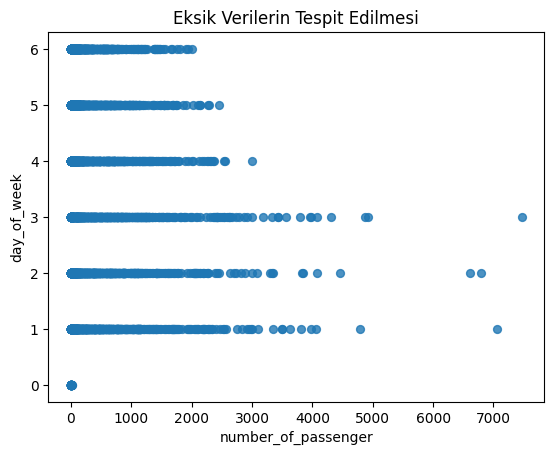

In [ ]:
from matplotlib import pyplot as plt
grouped_data.plot(kind='scatter', x='number_of_passenger', title="Eksik Verilerin Tespit Edilmesi", y='day_of_week', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(True)

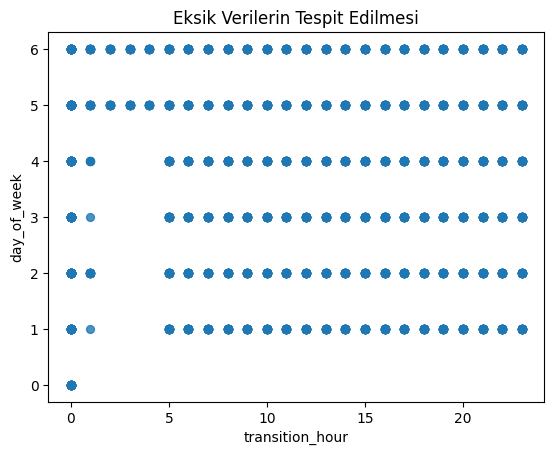

In [ ]:
from matplotlib import pyplot as plt
grouped_data.plot(kind='scatter', x='transition_hour', y='day_of_week', title="Eksik Verilerin Tespit Edilmesi", s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(True)

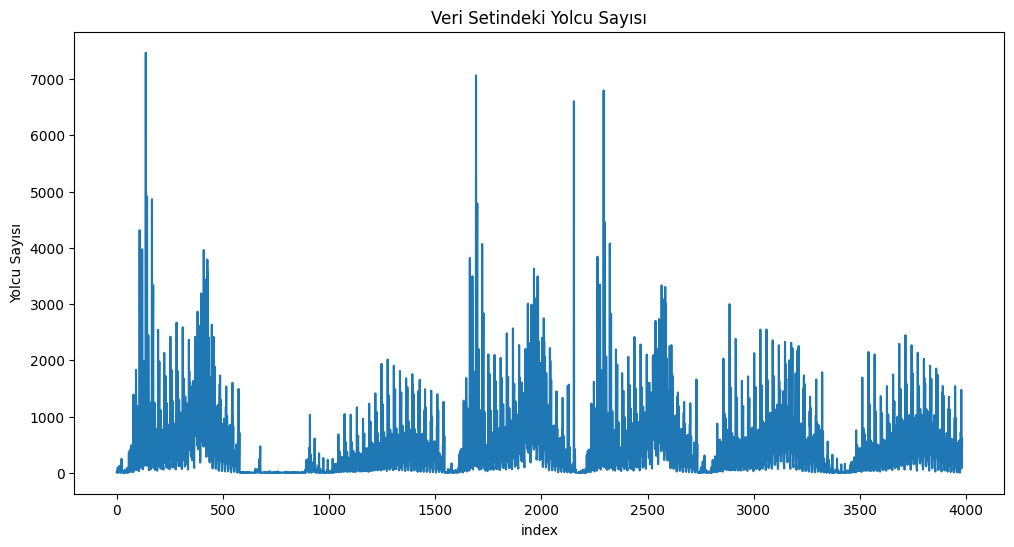

In [ ]:
grouped_data['number_of_passenger'].plot(kind='line', figsize=(12,6), title='Veri Setindeki Yolcu Sayısı')
plt.xlabel('index')
plt.ylabel('Yolcu Sayısı')
plt.show()

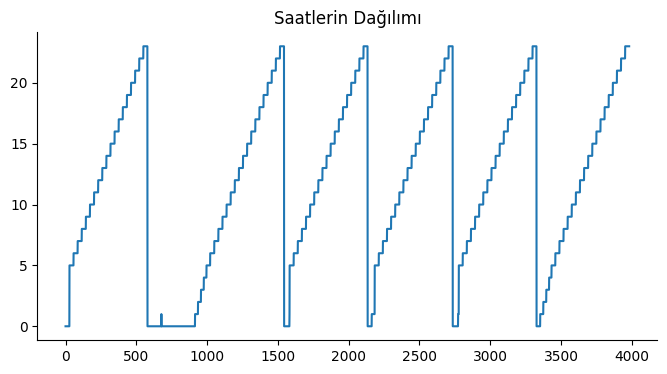

In [ ]:
grouped_data['transition_hour'].plot(kind='line', figsize=(8, 4), title='Saatlerin Dağılımı')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# One-hot encoding uygulama
column_transformer = ColumnTransformer(
    transformers=[
        ('day_of_week_ohe', OneHotEncoder(), ['day_of_week']),
        ('station_ohe', OneHotEncoder(), ['station_poi_desc_cd'])
    ],
    remainder='passthrough'
)
features = column_transformer.fit_transform(grouped_data[['transition_hour', 'day_of_week', 'station_poi_desc_cd']]).toarray()  # Dense formata dönüştür

# Hedef değişkeni ayır
target = grouped_data['number_of_passenger'].values.reshape(-1, 1)

# Hedef değişkeni normalleştir
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target)

In [ ]:
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step), :]
        X.append(a)
        y.append(target[i + time_step, 0])
    return np.array(X), np.array(y)


timestep seçimi

In [ ]:
time_step = 12 ### HYPERPARAMETER: modelde kullanılacak örnek sayısı: (N - time_step - 1)

X, y = create_dataset(features, target, time_step)
print(X.shape)
print(y.shape)

(3969, 12, 37)
(3969,)


In [ ]:
if len(X.shape) == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Veriyi train-validation-test olarak ayır
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
y_test, y_train, y_val

(array([3.21280300e-01, 1.53073524e-01, 4.53997589e-02, 4.78103656e-02,
        0.00000000e+00, 1.18387572e-01, 1.50261149e-01, 5.59796438e-02,
        9.37458149e-04, 1.86152404e-02, 1.27226463e-02, 4.04446230e-02,
        2.54586849e-01, 3.72304808e-02, 3.26771126e-02, 1.33922593e-03,
        1.03254319e-01, 5.22298112e-03, 9.37458149e-04, 9.37458149e-04,
        8.12910138e-02, 1.00441945e-02, 1.33922593e-04, 1.47314852e-02,
        7.92821749e-02, 1.91509308e-02, 1.03120396e-02, 3.95071649e-02,
        1.04191777e-01, 6.69612964e-04, 1.90170082e-01, 2.57399223e-01,
        1.23208785e-02, 1.95526985e-02, 4.95513593e-02, 2.66505960e-02,
        6.34793090e-02, 2.71862863e-02, 4.74085978e-02, 4.15160037e-03,
        2.67845185e-04, 1.17182269e-01, 0.00000000e+00, 3.73644034e-02,
        7.05772064e-02, 3.28110352e-02, 9.91027186e-03, 7.64698005e-02,
        4.27213071e-02, 1.05798848e-02, 3.50877193e-02, 8.02196331e-02,
        3.37484934e-02, 3.09361189e-02, 4.12481586e-02, 5.423865

### Model oluşturma ve hyperparameter optimizasyonu

In [ ]:
# Hyperparameter settings
epochs = 50
batch_size = 32
learning_rate = 0.001
loss_function = 'mse'
activation_function = 'relu'

In [ ]:
model = Sequential()

model.add(GRU(50, return_sequences=True, activation=activation_function, input_shape=(time_step, X.shape[2])))  # Daha karmaşık model (GRU)
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True, activation=activation_function))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False, activation=activation_function))
model.add(Dropout(0.3))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 50)            13350     
                                                                 
 dropout (Dropout)           (None, 12, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 12, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
#plot_model(model, show_shapes=True)


In [ ]:
!pip install tensorflow==2.12
import tensorflow as tf

In [ ]:
# Checkpoint ve EarlyStopping ayarları
checkpoint = ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Modeli eğit
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpoint, early_stop])

Epoch 1/50
85/87 [============================>.] - ETA: 0s - loss: 0.0163
Epoch 1: val_loss improved from inf to 0.00622, saving model to best_model.h5.keras
87/87 [==============================] - 7s 35ms/step - loss: 0.0161 - val_loss: 0.0062
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.0072
Epoch 2: val_loss improved from 0.00622 to 0.00590, saving model to best_model.h5.keras
87/87 [==============================] - 2s 19ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0069
Epoch 3: val_loss improved from 0.00590 to 0.00573, saving model to best_model.h5.keras
87/87 [==============================] - 2s 18ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 4/50
85/87 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 4: val_loss improved from 0.00573 to 0.00532, saving model to best_model.h5.keras
87/87 [==============================] - 2s 18ms/step - loss: 0.0066 - val_loss: 0.0053


### Model performansı

In [ ]:
# # Test verisi ile tahmin yap ve performansı ölç
# y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# # RMSE hesapla
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'Test RMSE: {rmse}')
# # r-square hesapla
# Test verisi ile tahmin yap ve performansı ölç
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE hesapla
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')
# r-square hesapla
r2 = r2_score(y_test, y_pred)
print(f'Test R²: {r2}')
print(f'y_test.shape:{y_test.shape}', f'y_pred.shape:{y_pred.shape}', f'y_train.shape:{y_train.shape}',f'y_val.shape:{y_val.shape}')

19/19 [==============================] - 1s 5ms/step
Test RMSE: 233.11870825186838
Test R²: 0.8614548510099914
y_test.shape:(596, 1) y_pred.shape:(596, 1) y_train.shape:(2778,) y_val.shape:(595,)


In [ ]:
y_test.shape, y_pred.shape, y_train.shape, y_val.shape

((596, 1), (596, 1), (2778,), (595,))

In [ ]:

# Test ve tahmin sonuçlarını saatlik karşılaştırmalı tablo olarak göster
comparison_df = pd.DataFrame({'Real Values': y_test.flatten(), 'Predicted Values': y_pred.flatten()})
print(comparison_df)


     Real Values  Predicted Values
0         2400.0       2087.013428
1         1144.0       1025.382568
2          340.0        204.913239
3          358.0        510.650970
4            1.0        103.727592
..           ...               ...
591         11.0        121.686890
592       1268.0       1134.937866
593       2670.0       2340.087158
594       1278.0       1182.144653
595         32.0        162.174515

[596 rows x 2 columns]


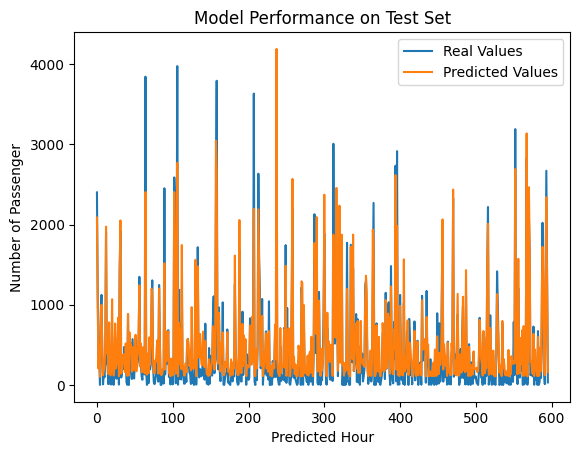

In [ ]:
plt.plot(y_test, label='Real Values', linestyle='-', marker='none')
plt.plot(y_pred, label='Predicted Values', linestyle='-', marker='none')
plt.xlabel('Predicted Hour')
plt.ylabel('Number of Passenger')
plt.title('Model Performance on Test Set')
plt.legend()
plt.show()

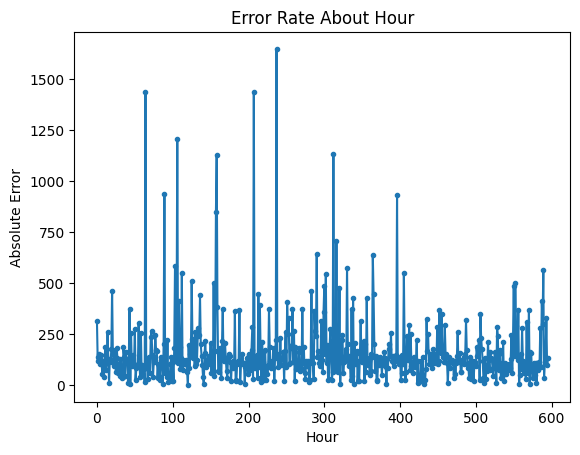

In [ ]:
# Gerçek değerler (y_test) ve tahmin değerleri (y_pred) arasındaki mutlak farkları hesapla
errors = np.abs(y_test - y_pred)
errors = errors.flatten()

plt.plot(errors, label='Absolute Error', linestyle='-', marker=".")
plt.xlabel('Hour')
plt.ylabel('Absolute Error')
plt.title('Error Rate About Hour')
plt.show()


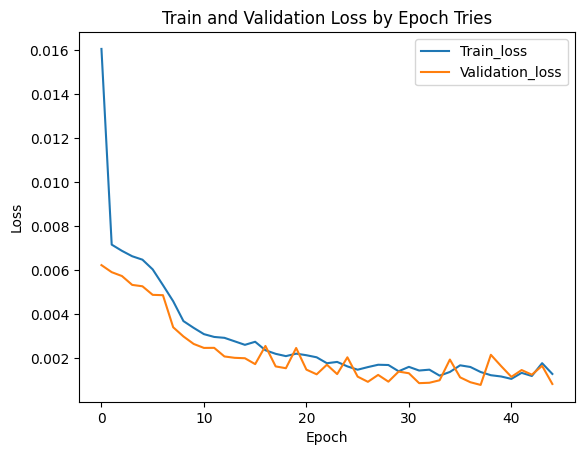

In [ ]:
# Eğitim ve doğrulama kaybını görselleştir
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Epoch Tries')
plt.legend()
plt.show()

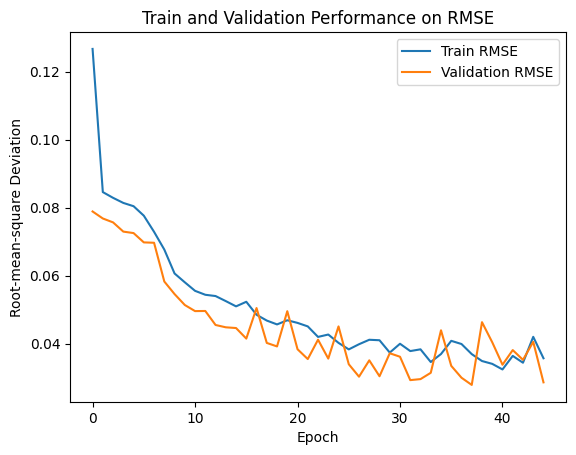

In [ ]:
# RMSE hata grafiğini göster
plt.plot(np.sqrt(history.history['loss']), label='Train RMSE')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root-mean-square Deviation')
plt.title('Train and Validation Performance on RMSE')
plt.legend()
plt.show()

### Prediction

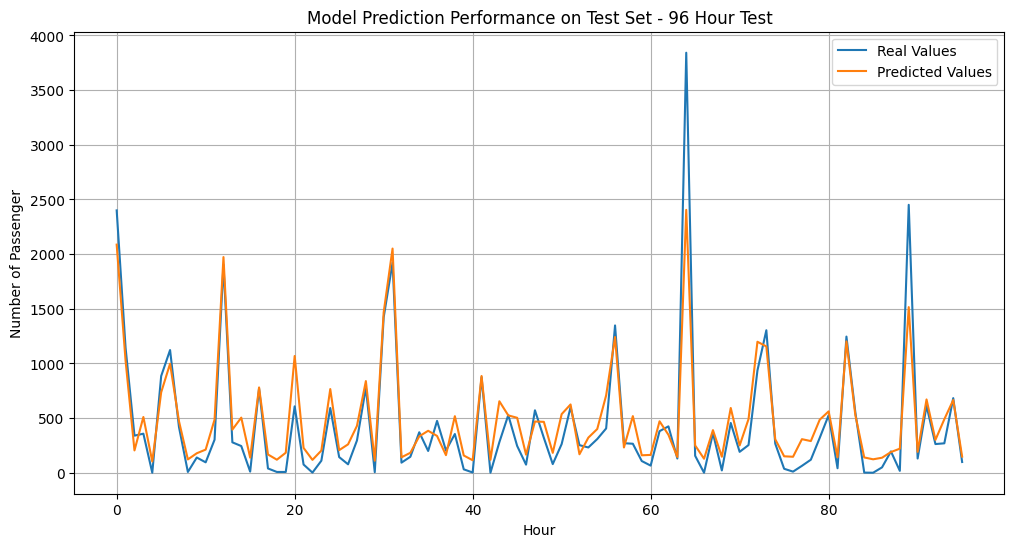

In [ ]:

num_days = 4  # Kaç günlük veri kullanılacağı

def plot_results_one_station_seven_days(actual, predicted, title, num_days):
    actual_station = actual.flatten()[:num_days * 24]
    predicted_station = predicted.flatten()[:num_days * 24]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_station, label="Real Values", marker='')
    plt.plot(predicted_station, label="Predicted Values", marker='')
    plt.title(f"{title} - {num_days*24} Hour Test")
    plt.xlabel("Hour")
    plt.ylabel("Number of Passenger")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test seti için belirli bir istasyonun sonuçlarını görselleştir
plot_results_one_station_seven_days(y_test, y_pred, "Model Prediction Performance on Test Set", num_days)


## Ekstras

In [ ]:
# Hyperparameter settings
epochs = 40
batch_size = 64
learning_rate = 0.0001

In [ ]:
from tensorflow.keras.layers import Input, GRU, LSTM, Dropout, Dense

In [ ]:
# Model 1: İlk GRU modeli (tanh varsayılan aktivasyon ile)
input_layer_1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x1 = GRU(32, return_sequences=True)(input_layer_1)
x1 = Dropout(0.3)(x1)
x1 = GRU(16)(x1)
x1 = Dropout(0.3)(x1)
output_layer_1 = Dense(168, activation='linear')(x1)

model_1 = Model(inputs=input_layer_1, outputs=output_layer_1)
model_1.compile(optimizer=Adam(learning_rate=learning_rate), loss='huber_loss')


In [ ]:
# Model 2: ReLU aktivasyon fonksiyonu ile GRU modeli
input_layer_2 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x2 = GRU(32, activation='relu', return_sequences=True)(input_layer_2)
x2 = Dropout(0.3)(x2)
x2 = GRU(16, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
output_layer_2 = Dense(168, activation='linear')(x2)

model_2 = Model(inputs=input_layer_2, outputs=output_layer_2)
model_2.compile(optimizer=Adam(learning_rate=learning_rate), loss='huber_loss')


In [ ]:
# Model 3: İlk LSTM modeli
input_layer_3 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x3 = LSTM(64, return_sequences=True)(input_layer_3)
x3 = Dropout(0.3)(x3)
x3 = LSTM(32)(x3)
x3 = Dropout(0.3)(x3)
output_layer_3 = Dense(168, activation='linear')(x3)

model_3 = Model(inputs=input_layer_3, outputs=output_layer_3)
model_3.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')


In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:

# Model 1 eğitimi
history_1 = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
35/35 [==============================] - 5s 38ms/step - loss: 0.0261 - val_loss: 0.0160
Epoch 2/40
35/35 [==============================] - 1s 15ms/step - loss: 0.0194 - val_loss: 0.0118
Epoch 3/40
35/35 [==============================] - 1s 15ms/step - loss: 0.0156 - val_loss: 0.0095
Epoch 4/40
35/35 [==============================] - 1s 14ms/step - loss: 0.0133 - val_loss: 0.0081
Epoch 5/40
35/35 [==============================] - 1s 15ms/step - loss: 0.0115 - val_loss: 0.0071
Epoch 6/40
35/35 [==============================] - 1s 15ms/step - loss: 0.0102 - val_loss: 0.0065
Epoch 7/40
35/35 [==============================] - 0s 14ms/step - loss: 0.0094 - val_loss: 0.0060
Epoch 8/40
35/35 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 9/40
35/35 [==============================] - 0s 14ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 10/40
35/35 [==============================] - 1s 14ms/step - loss: 0.0075 - val_loss: 0.0051
Epoch 11/

In [ ]:

# Model 2 eğitimi
history_2 = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
35/35 [==============================] - 3s 26ms/step - loss: 0.1091 - val_loss: 0.0578
Epoch 2/40
35/35 [==============================] - 0s 14ms/step - loss: 0.0759 - val_loss: 0.0393
Epoch 3/40
35/35 [==============================] - 0s 13ms/step - loss: 0.0539 - val_loss: 0.0280
Epoch 4/40
35/35 [==============================] - 0s 13ms/step - loss: 0.0396 - val_loss: 0.0205
Epoch 5/40
35/35 [==============================] - 0s 12ms/step - loss: 0.0287 - val_loss: 0.0156
Epoch 6/40
35/35 [==============================] - 0s 12ms/step - loss: 0.0220 - val_loss: 0.0119
Epoch 7/40
35/35 [==============================] - 0s 12ms/step - loss: 0.0164 - val_loss: 0.0089
Epoch 8/40
35/35 [==============================] - 0s 13ms/step - loss: 0.0120 - val_loss: 0.0073
Epoch 9/40
35/35 [==============================] - 0s 13ms/step - loss: 0.0095 - val_loss: 0.0064
Epoch 10/40
35/35 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 11/

In [ ]:

# Model 3 eğitimi
history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
35/35 [==============================] - 5s 43ms/step - loss: 0.0187 - val_loss: 0.0134
Epoch 2/40
35/35 [==============================] - 1s 19ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 3/40
35/35 [==============================] - 1s 18ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 4/40
35/35 [==============================] - 1s 18ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 5/40
35/35 [==============================] - 1s 18ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 6/40
35/35 [==============================] - 1s 18ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 7/40
35/35 [==============================] - 1s 18ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 8/40
35/35 [==============================] - 1s 18ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 9/40
35/35 [==============================] - 1s 19ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 10/40
35/35 [==============================] - 1s 19ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 11/

In [ ]:
 # Test sonuçlarını değerlendirme
y_test_pred_1 = model_1.predict(X_test)
y_test_pred_2 = model_2.predict(X_test)
y_test_pred_3 = model_3.predict(X_test)

# RMSE hesaplama
test_rmse_1 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_1.flatten()))
test_rmse_2 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_2.flatten()))
test_rmse_3 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_3.flatten()))

print("Model 1 (GRU, varsayılan aktivasyon) Test Seti RMSE:", test_rmse_1)
print("Model 2 (GRU, ReLU aktivasyon) Test Seti RMSE:", test_rmse_2)
print("Model 3 (LSTM) Test Seti RMSE:", test_rmse_3)

19/19 [==============================] - 1s 5ms/step


ValueError: Found input variables with inconsistent numbers of samples: [596, 100128]

In [ ]:
def plot_results_one_station_seven_days(actual, predicted, title, station_index=2, num_days=1):
    """Plots the actual and predicted values for one station for seven days.

    Args:
        actual: The actual values.
        predicted: The predicted values.
        title: The title of the plot.
        station_index: The index of the station to plot.
        num_days: The number of days to plot.
    """

    plt.figure(figsize=(12, 6))

    # Get data for the specified station and number of days
    actual_station = actual[station_index, :num_days * 168]
    predicted_station = predicted[station_index, :num_days * 168]

    plt.plot(actual_station, label="Actual", marker='o')
    plt.plot(predicted_station, label="Predicted", marker='x')
    plt.title(f"{title} - Station {station_index + 1}")
    plt.xlabel("Hours (Over 7 Days)")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming y_test and y_test_pred are your actual and predicted values
# and they have shape (num_stations, num_hours)
plot_results_one_station_seven_days(y_test, y_test_pred, "Model Evaluation on Test Set (Hourly Predictions)")

In [ ]:
#EOF

In [ ]:
#checkpoint = ModelCheckpoint('/kaggle/working/model_checkpoint.h5.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
#model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

In [ ]:
# Load the best model
#model.load_weights('/kaggle/working/model_checkpoint.h5.keras')

In [ ]:
# Make predictions on the test set
#predictions = model.predict(X_test)



```
# @title Varsayılan başlık metni
# Define LSTM model with Bidirectional LSTM layers
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.3)(x)
output_layer = Dense(168, activation='linear')(x)  # Predicting 168 hourly values

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on test data with RMSE
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
print("RMSE on Test Set:", test_rmse)
```
Epoch 1/15
634/634 [==============================] - 78s 118ms/step - loss: 6141.9287 - val_loss: 6013.4131
Epoch 2/15
634/634 [==============================] - 72s 114ms/step - loss: 5807.7456 - val_loss: 5875.2275
Epoch 3/15
634/634 [==============================] - 74s 117ms/step - loss: 5748.2134 - val_loss: 5854.4795
Epoch 4/15
634/634 [==============================] - 72s 114ms/step - loss: 5739.8740 - val_loss: 5851.9917
Epoch 5/15
634/634 [==============================] - 73s 116ms/step - loss: 5738.8394 - val_loss: 5851.5781
Epoch 6/15
634/634 [==============================] - 74s 117ms/step - loss: 5739.0259 - val_loss: 5851.5020
Epoch 7/15
634/634 [==============================] - 75s 118ms/step - loss: 5738.7144 - val_loss: 5851.4937
Epoch 8/15
634/634 [==============================] - 74s 116ms/step - loss: 5739.0679 - val_loss: 5851.4424
Epoch 9/15
634/634 [==============================] - 75s 119ms/step - loss: 5738.7021 - val_loss: 5851.4126
Epoch 10/15
634/634 [==============================] - 75s 118ms/step - loss: 5738.5425 - val_loss: 5851.4214
Epoch 11/15
634/634 [==============================] - 73s 115ms/step - loss: 5738.9507 - val_loss: 5851.4126
Epoch 12/15
634/634 [==============================] - 74s 117ms/step - loss: 5738.5063 - val_loss: 5844.7988
Epoch 13/15
634/634 [==============================] - 73s 116ms/step - loss: 5728.2959 - val_loss: 5839.5508
Epoch 14/15
634/634 [==============================] - 75s 119ms/step - loss: 5717.6406 - val_loss: 5831.8447
Epoch 15/15
634/634 [==============================] - 72s 113ms/step - loss: 5709.9351 - val_loss: 5803.7725

[94]
# Evaluate the model on test data with RMSE
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
print("RMSE on Test Set:", test_rmse)
198/198 [==============================] - 7s 33ms/step
RMSE on Test Set: 75.64395273291461
